# Designing a topography-conforming mesh

This notebook shows how to setup a 2-D or 3-D mesh which fits topography. It is recommended that you first go through the **01_example_2D_MT_CSEM_modeling** tutorial before this one.

*Created by A. Grayver, 2019*

Let us start by including some common packages

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

Next, let the python know where deal.II's python package lives and also include pyGoFEM tools

In [2]:
module_path = os.path.abspath('/home/agrayver/lib/dealii/build_gofem/lib/python3.7/site-packages')
if module_path not in sys.path:
    sys.path.append(module_path)

import PyDealII.Release as dealii

from gofem.parameter_handler import *
from gofem.mesh_utils import *

## 2-D example

Create an initial coarse mesh.

In [3]:
dy = np.ones(shape=4) * 25000
dz = dy.copy()
mesh_size = np.array([np.sum(dy), np.sum(dz)])

p_origin = dealii.Point((-mesh_size / 2.).tolist())
p_end = dealii.Point((mesh_size / 2.).tolist())

triangulation = dealii.Triangulation('2D')
triangulation.generate_subdivided_steps_hyper_rectangle([dy.tolist(), dz.tolist()], p_origin, p_end, False)
triangulation.refine_global(2)

Now we can plot the mesh:

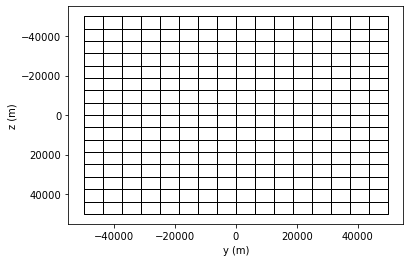

In [4]:
fig, ax = plot_2d_triangulation(triangulation)

One of the most powerful features of GoFEM is locally refined meshes, which allow us to refine only in regions where it is needed. like at the air-ground interface. To do that, we first need to assign some physical properties to cells. We mark each cell with a material id. In particular, all cells above the ground are given material id one and the rest will have id two:

In [5]:
for cell in triangulation.active_cells():
    if cell.center().y < 0:
        cell.material_id = 1
    else:
        cell.material_id = 2

In [6]:
materials = {1: ('air', 1e-8), 2: ('ground', 0.01)}

Here, each material id is linked to a pair of values, representing its name and conductivity value (in *S/m*). This allows us to plot the mesh with conductivity assigned to each cell

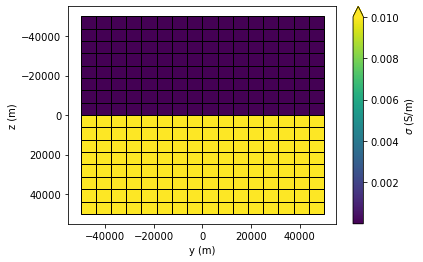

In [7]:
def color(cell):
    return materials[cell.material_id][1]

fig, ax = plot_2d_triangulation(triangulation, color_scheme=color)
fig.colorbar(ax.collections[0], ax=ax,\
             orientation = 'vertical',\
             label = r'$\sigma$ (S/m)',\
             norm=colors.LogNorm(vmin = 1e-8, vmax = 1e-2),\
             extend='max')

Finally, we can call a convenience function to refine at the air-ground interface

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbafef59b70>)

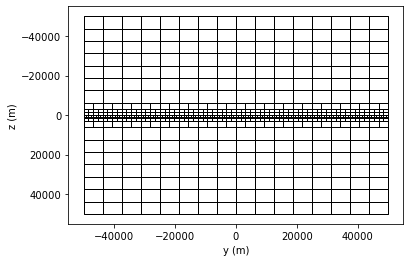

In [8]:
refine_at_interface(triangulation, material_ids = [2], repeat = 3)
plot_2d_triangulation(triangulation)

In this case, we did it twice and we excluded the air itself from refinement since accuracy in the air is less important. We can further refine only the central part since our receivers will be placed there

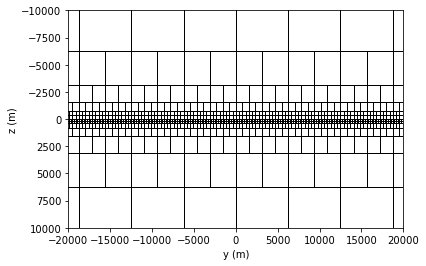

In [9]:
refine_at_interface(triangulation, material_ids = [2], repeat = 2, center = [0,0], radius = [50000])
fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-20000, 20000])
ax.set_ylim([-10000, 10000])
ax.invert_yaxis()

Let us see how many cells we have now and what is the diameter of the smallest and largest cells

In [10]:
print('# of cells = %d\nsmallest cell = %0.1f m\nlargest cell = %0.1f m' % (triangulation.n_active_cells(),\
                                                                      triangulation.minimal_cell_diameter(),\
                                                                      triangulation.maximal_cell_diameter()))

# of cells = 2464
smallest cell = 276.2 m
largest cell = 8838.8 m


Now, we can read in the topography

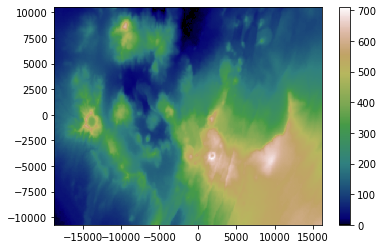

In [11]:
data = np.loadtxt('topodata.xyz', delimiter = '\t')

n = 284
m = 466

x = np.reshape(data[:,0], (n,m))
y = np.reshape(data[:,1], (n,m))
z = np.reshape(data[:,2], (n,m))

plt.pcolormesh(y,x,-z, cmap='gist_earth')
plt.colorbar()

#x = np.squeeze(x[:,0])
#y = np.squeeze(y[0,:])

This is a real topography from the Rift Valley in Ethiopia, namely the area around Tulu Moye volcanic field (Samrock et al. 2018). Note that the coordinates were already transformed to the UTM and centered.

Since this is a 2-D example, we will extract a single profile and fit our mesh to it:

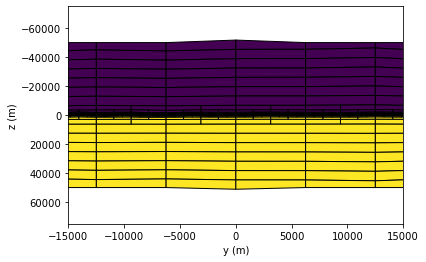

In [12]:
topofunc = RegularGridInterpolator((np.squeeze(y[150,:]),), np.squeeze(z[150,:]), bounds_error = False)

def topofunc_callback(p):
    return topofunc([p])[0]

topo = Topography(topofunc_callback, dim = 2, center = [0,0], radius = [50000, 50000])

topo.fit_to(triangulation, z_top = -1e4, z_bottom = 1e4)

fig, ax = plot_2d_triangulation(triangulation, color_scheme=color)
ax.set_xlim([-15000, 15000])
ax.set_ylim([-75000, 75000])
ax.invert_yaxis()

# You can also revert the transformation. 
#topo.fit_to(triangulation, z_top = -1e4, z_bottom = 1e4, inverse = True)
#fig, ax = plot_2d_triangulation(triangulation, color_scheme=color)
#ax.set_xlim([-15000, 15000])
#ax.set_ylim([-75000, 75000])
#ax.invert_yaxis()

Now, let's create a list of receivers:

In [13]:
receivers_y = np.arange(-13000., 13000., 1000.)
receivers = []
for ry in receivers_y:
    receivers.append([ry, 0.])

Currently, these receivers are just placed at the sea level. However, they should lie at the air-ground interface (or a little below it) of the deformed mesh. To achieve this, we can use a pyGoFEM function as below

In [14]:
mapping = dealii.MappingQGeneric(dim = 2, spacedim = 2, degree = 1)
receivers_projected = project_points_on_interface(triangulation = triangulation, points = receivers, material_id = 1, mapping = mapping)

receivers_y = []
receivers_z = []
for r in receivers_projected:
    receivers_y.append(r[0])
    receivers_z.append(r[1] + 0.1)

Now let us plot the mesh with the projected receivers

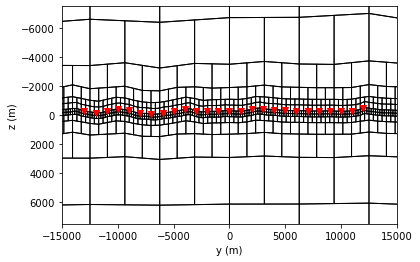

In [15]:
fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-15000, 15000])
ax.set_ylim([-7500, 7500])
ax.invert_yaxis()
ax.scatter(receivers_y, receivers_z, color='r', marker='v')

Note that for CSEM exactly the same function can be used to project sources.

The mesh and projected receivers can now be saved for GoFEM. We will not repeat this here since it is exactly the same as **01_example_2D_MT_CSEM_modeling** 

## 3-D Example

Creating 3-D mesh is essentially the same as 2-D here. Obviously, we have now all three coordinates (with *z* pointing down and *x* to the North). The only other caveat is that, unlike in 2-D, we cannot easily visualize a 3-D mesh. 

Some 3-D python visualization tools exist and can be used, but we will not load this tutorial with technical details on 3-D visualization. Instead, our approach will be more *naive*. We will save 3-D mesh at different stages in a *VTK* format and invoke ParaView to visualize them externally. Some screenshots from ParaView will be inserted here to facilitate the understanding.

Let us start by creating a regular coarse mesh:

In [16]:
dx = np.ones(shape=4) * 25000
dy = dx.copy()
dz = np.array([40000, 30000, 20000, 20000, 30000, 40000])
mesh_size = np.array([np.sum(dx), np.sum(dy), np.sum(dz)])

p_origin = dealii.Point((-mesh_size / 2.).tolist())
p_end = dealii.Point((mesh_size / 2.).tolist())

triangulation = dealii.Triangulation('3D')
triangulation.generate_subdivided_steps_hyper_rectangle([dx.tolist(), dy.tolist(), dz.tolist()], p_origin, p_end, False)
triangulation.refine_global(2)

We will use the same properties we defined in the 2-D example above

In [17]:
for cell in triangulation.active_cells():
    if cell.center().z < 0:
        cell.material_id = 1
    else:
        cell.material_id = 2

Now refine at the air-ground interface

In [18]:
refine_at_interface(triangulation, material_ids = [2], repeat = 2)
refine_at_interface(triangulation, material_ids = [2], repeat = 1, center = [0,0,0], radius = [30000,30000])
refine_at_interface(triangulation, material_ids = [2], repeat = 1, center = [0,0,0], radius = [12000,18000])

Create a regular grid of receivers and refine mesh around these points once

In [19]:
ry = np.arange(-10000., 10000., 1000.)
rx = ry.copy()

rxx, ryy = np.meshgrid(rx, ry)
rxx = rxx.flatten()
ryy = ryy.flatten()

receivers = []
for i in range(rxx.shape[0]):
    receivers.append([rxx[i], ryy[i], 0.])
    
refine_around_points(triangulation, points = receivers,\
                     center = [0, 0, 0], radius = [600, 600, 600],\
                     repeat = 1, exclude_materials = [1])

refine_around_points(triangulation, points = receivers,\
                     center = [0, 0, 0], radius = [300, 300, 300],\
                     repeat = 1, exclude_materials = [1])

Print some information about the mesh

In [20]:
print('# of cells = %d\nsmallest cell = %0.1f m\nlargest cell = %0.1f m' % (triangulation.n_active_cells(),\
                                                                      triangulation.minimal_cell_diameter(),\
                                                                      triangulation.maximal_cell_diameter()))

# of cells = 125858
smallest cell = 158.7 m
largest cell = 13346.3 m


Now we see that the number of cells is larger than in 2-D, but this is inevitable when working in 3D. However, the number of cells is still modest and, thanks to the locally refined mesh, we have a sufficiently fine mesh at the surface, so we can accurately represent the topography

In [21]:
x = np.squeeze(x[:,0])
y = np.squeeze(y[0,:])

topofunc = RegularGridInterpolator((x,y), z, bounds_error = False)

def topofunc_callback(p):
    return topofunc([p])[0]

topo = Topography(topofunc_callback, dim = 3, center = [0,0,0], radius = [50000, 50000, 50000])
topo.fit_to(triangulation, z_top = -1e4, z_bottom = 1e4)

triangulation.write('./02/topo_3D_mesh.vtu', 'vtu')

Project receivers to the mesh topography:

In [22]:
mapping = dealii.MappingQGeneric(dim = 3, spacedim = 3, degree = 1)
receivers_projected = project_points_on_interface(triangulation = triangulation, points = receivers, material_id = 1, mapping = mapping)

with open('./02/receivers', 'w') as f:
    idx = 0
    for rec in receivers_projected:
        f.write("Dipole R%d 1 %0.6e %0.6e %0.6e\n" % (idx, rec[0], rec[1], rec[2]+0.1))
        idx += 1

This is how our mesh with the projected receivers look like in ParaView:

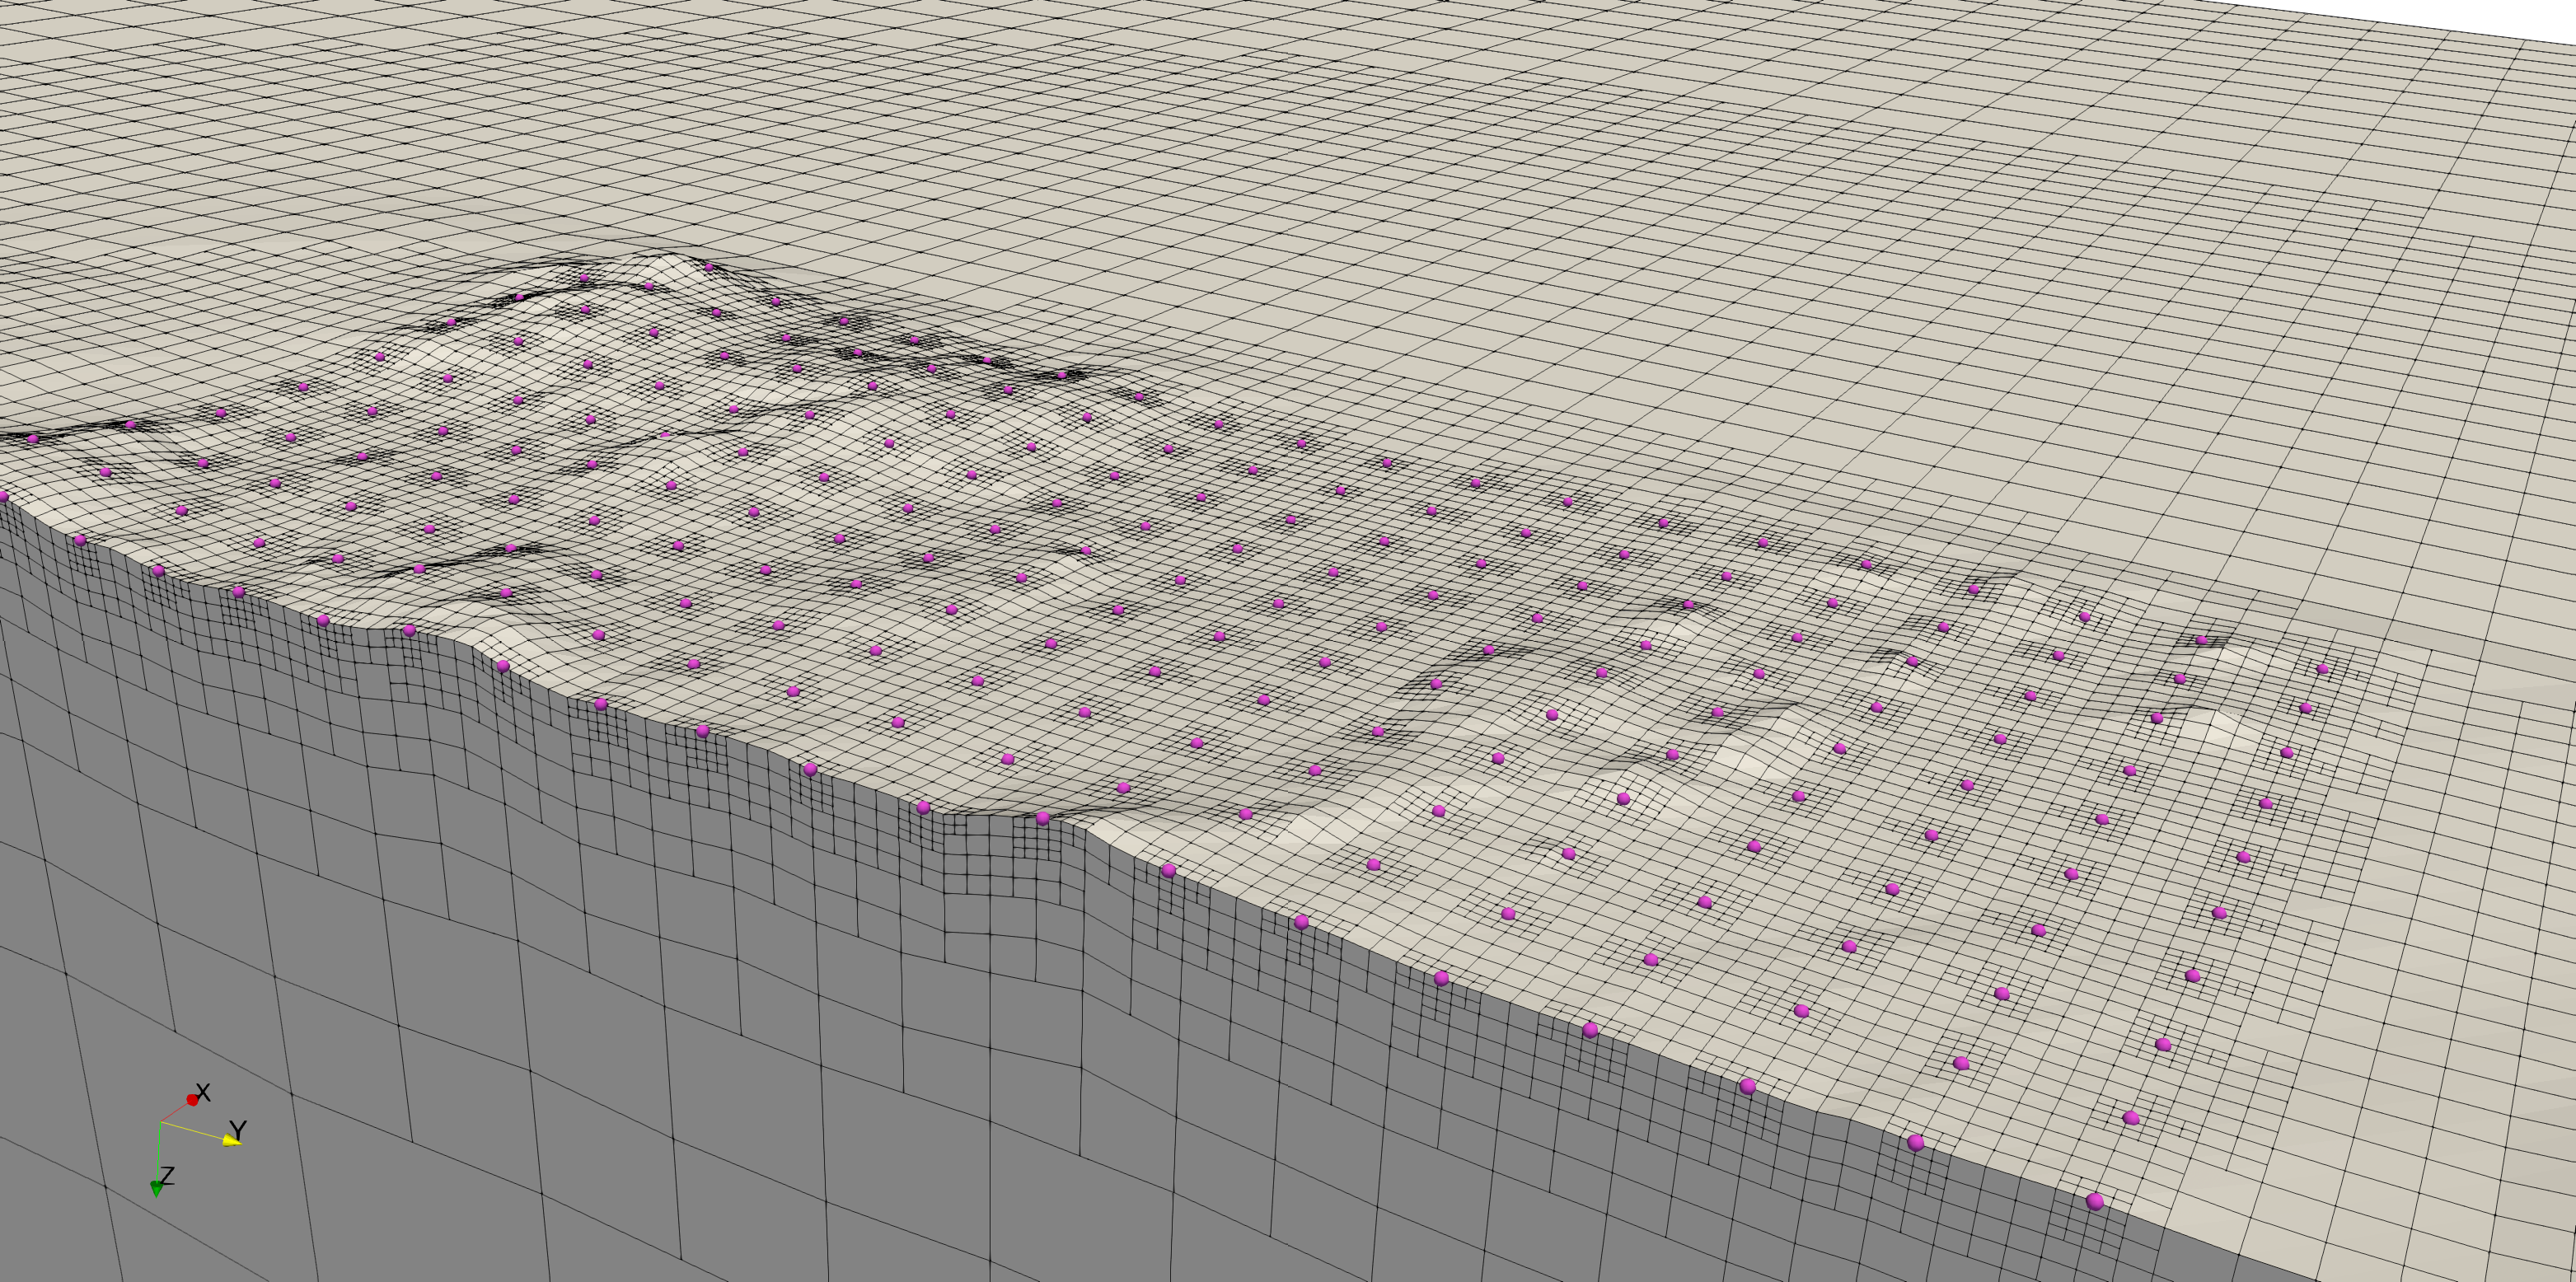

In [23]:
from IPython.display import Image
Image(filename='./02/topo_3D_mesh.png') 